## Pointwise Model Training

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import json
import os
import pickle
import pandas as pd
import torch

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
rows = []
data_dir = "/content/drive/MyDrive/data"
with open(os.path.join(data_dir, "candidate-queries-features.jsonl"), "r") as fin:
  for line in fin:
    json_line = json.loads(line.strip())
    rows.append(json_line)

In [ ]:
len(rows)

4943

In [ ]:
len(rows[0])

62

In [ ]:
df = pd.DataFrame(rows)
df.head()

,num_query_tokens,num_title_tokens,num_section_title_tokens,num_bread_crumb_tokens,num_text_tokens,num_title_token_overlap,num_section_title_token_overlap,num_bread_crumb_token_overlap,num_text_token_overlap,title_concept_overlap,...,text_var_tf,text_min_tfidf,text_max_tfidf,text mean_tfidf,text_var_tfidf,title_vec_score,section_title_vec_score,bread_crumb_vec_score,text_vec_score,label
0,3,1,2,5,286,0,0,0,2,0,...,4.040502,0.183206,52.409880,6.227678,38.665046,0.817681,0.072743,0.211973,0.604541,1
1,3,1,1,4,81,0,0,0,2,0,...,0.745124,0.115926,29.645081,5.509683,32.488344,0.817681,0.110808,0.251098,0.647505,0
2,3,1,1,2,269,0,0,0,2,0,...,7.302085,0.205532,88.935242,6.872399,111.506575,0.817681,0.004833,0.022811,0.609198,1
3,3,1,2,3,260,0,0,0,2,0,...,1.425995,0.178530,44.552584,6.018126,42.014581,0.817681,0.141400,0.141922,0.503128,1
4,3,1,2,5,57,0,0,0,2,0,...,0.058594,0.044632,13.102470,4.007278,7.067541,0.817681,0.072743,0.211973,0.619005,1


In [ ]:
# got these using polars
int_cols = ['num_query_tokens', 'num_title_tokens', 'num_section_title_tokens',
  'num_bread_crumb_tokens', 'num_text_tokens', 'num_title_token_overlap',
  'num_section_title_token_overlap', 'num_bread_crumb_token_overlap',
  'num_text_token_overlap', 'title_concept_overlap', 'section_title_concept_overlap',
  'bread_crumb_concept_overlap', 'text_concept_overlap', 'title_stygroup_overlap',
  'section_title_stygroup_overlap', 'bread_crumb_stygroup_overlap', 'text_stygroup_overlap',
  'title_ttf', 'title_min_tf', 'title_max_tf', 'section_title_ttf', 'section_title_min_tf',
  'section_title_max_tf', 'bread_crumb_ttf', 'bread_crumb_min_tf', 'bread_crumb_max_tf',
  'text_ttf', 'text_min_tf', 'text_max_tf']
float_cols = ['title_bm25_score', 'section_title_bm25_score', 'bread_crumb_bm25_score',
  'text_bm25_score', 'title mean_tf', 'title_var_tf', 'title_min_tfidf',
  'title_max_tfidf', 'title mean_tfidf', 'title_var_tfidf', 'section_title mean_tf',
  'section_title_var_tf', 'section_title_min_tfidf', 'section_title_max_tfidf',
  'section_title mean_tfidf', 'section_title_var_tfidf', 'bread_crumb mean_tf',
  'bread_crumb_var_tf', 'bread_crumb_min_tfidf', 'bread_crumb_max_tfidf',
  'bread_crumb mean_tfidf', 'bread_crumb_var_tfidf', 'text_mean_tf', 'text_var_tf',
  'text_min_tfidf', 'text_max_tfidf', 'text mean_tfidf', 'text_var_tfidf',
  'title_vec_score', 'section_title_vec_score', 'bread_crumb_vec_score', 'text_vec_score']


def scale_features(df, int_cols, float_cols):
  feature_scalers = {}
  for colname in int_cols:
    scaler = MinMaxScaler()
    df[colname] = scaler.fit_transform(df[colname].values.reshape(-1, 1))
    feature_scalers[colname] = scaler
  for colname in float_cols:
    scaler = StandardScaler()
    df[colname] = scaler.fit_transform(df[colname].values.reshape(-1, 1))
    feature_scalers[colname] = scaler
  return feature_scalers


feat_scalers = scale_features(df, int_cols, float_cols)
with open(os.path.join(data_dir, "feat_scalers.pickle"), "wb") as handle:
    pickle.dump(feat_scalers, handle, protocol=pickle.HIGHEST_PROTOCOL)

df.head()

,num_query_tokens,num_title_tokens,num_section_title_tokens,num_bread_crumb_tokens,num_text_tokens,num_title_token_overlap,num_section_title_token_overlap,num_bread_crumb_token_overlap,num_text_token_overlap,title_concept_overlap,...,text_var_tf,text_min_tfidf,text_max_tfidf,text mean_tfidf,text_var_tfidf,title_vec_score,section_title_vec_score,bread_crumb_vec_score,text_vec_score,label
0,0.142857,0.0,0.1,0.16,0.397472,0.0,0.0,0.0,0.285714,0.0,...,0.185837,0.036410,0.592845,0.222513,-0.079493,2.189143,-0.576883,0.216013,1.433141,1
1,0.142857,0.0,0.0,0.12,0.109551,0.0,0.0,0.0,0.285714,0.0,...,-0.469576,-0.218405,-0.303410,-0.100145,-0.157119,2.189143,-0.317772,0.481390,1.664080,0
2,0.142857,0.0,0.0,0.04,0.373596,0.0,0.0,0.0,0.285714,0.0,...,0.834528,0.120964,2.030857,0.512243,0.835956,2.189143,-1.039148,-1.067055,1.458176,1
3,0.142857,0.0,0.1,0.08,0.360955,0.0,0.0,0.0,0.285714,0.0,...,-0.334159,0.018699,0.283502,0.128343,-0.037397,2.189143,-0.109527,-0.259137,0.888037,1
4,0.142857,0.0,0.1,0.16,0.075843,0.0,0.0,0.0,0.285714,0.0,...,-0.606119,-0.488421,-0.954696,-0.775307,-0.476600,2.189143,-0.576883,0.216013,1.510887,1


In [ ]:
data = df.to_numpy()
X, y = data[:, 0:-1], data[:, -1]
X.shape, y.shape

((4943, 61), (4943,))

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)
Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape

((3954, 61), (3954,), (989, 61), (989,))

In [ ]:
clf = SVC()
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)
acc = accuracy_score(ytest, ypred)
print(acc)

0.7937310414560161


In [ ]:
Xtv, Xtest, ytv, ytest = train_test_split(X, y, test_size=0.2, random_state=42)
Xtrain, Xval, ytrain, yval = train_test_split(Xtv, ytv, test_size=0.1, random_state=42)

train_dataset = TensorDataset(torch.Tensor(Xtrain), torch.Tensor(ytrain))
val_dataset = TensorDataset(torch.Tensor(Xval), torch.Tensor(yval))
test_dataset = TensorDataset(torch.Tensor(Xtest), torch.Tensor(ytest))

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32)
test_dataloader = DataLoader(test_dataset, batch_size=32)

In [ ]:
Xtrain.shape

(3558, 61)

In [ ]:
class PointwiseRanker(torch.nn.Module):
  def __init__(self, input_size, output_size):
    super().__init__()
    self.fc1 = torch.nn.Linear(input_size, 100)
    self.relu = torch.nn.ReLU()
    self.fc2 = torch.nn.Linear(100, output_size)
    # self.criterion = MSELoss()

  def forward(self, x):
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    return x

In [ ]:
model = PointwiseRanker(61, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
NUM_EPOCHS = 100

In [ ]:
history = []
for epoch in range(NUM_EPOCHS):
  train_losses = []
  for X, y in train_dataloader:
    logits = model(X)
    train_loss = F.mse_loss(logits, y.reshape(-1, 1))
    train_losses.append(train_loss)
    train_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  train_loss = torch.mean(torch.tensor(train_losses))
  # print("train loss: {:.3f}".format(train_loss))

  with torch.no_grad():
    val_losses = []
    for X, y in val_dataloader:
      logits = model(X)
      val_losses.append(F.mse_loss(logits, y.reshape(-1, 1)))
    val_loss = torch.mean(torch.tensor(val_losses))

    print("epoch {:d}, train_loss: {:.3f}, validation loss: {:.3f}".format(
        epoch, train_loss.item(), val_loss.item()))
    history.append((train_loss.item(), val_loss.item()))

epoch 0, train_loss: 0.266, validation loss: 0.189
epoch 1, train_loss: 0.163, validation loss: 0.178
epoch 2, train_loss: 0.154, validation loss: 0.178
epoch 3, train_loss: 0.149, validation loss: 0.174
epoch 4, train_loss: 0.144, validation loss: 0.178
epoch 5, train_loss: 0.144, validation loss: 0.184
epoch 6, train_loss: 0.142, validation loss: 0.173
epoch 7, train_loss: 0.139, validation loss: 0.171
epoch 8, train_loss: 0.137, validation loss: 0.174
epoch 9, train_loss: 0.136, validation loss: 0.178
epoch 10, train_loss: 0.135, validation loss: 0.170
epoch 11, train_loss: 0.134, validation loss: 0.173
epoch 12, train_loss: 0.131, validation loss: 0.171
epoch 13, train_loss: 0.130, validation loss: 0.175
epoch 14, train_loss: 0.130, validation loss: 0.169
epoch 15, train_loss: 0.127, validation loss: 0.177
epoch 16, train_loss: 0.128, validation loss: 0.171
epoch 17, train_loss: 0.126, validation loss: 0.169
epoch 18, train_loss: 0.126, validation loss: 0.169
epoch 19, train_loss: 

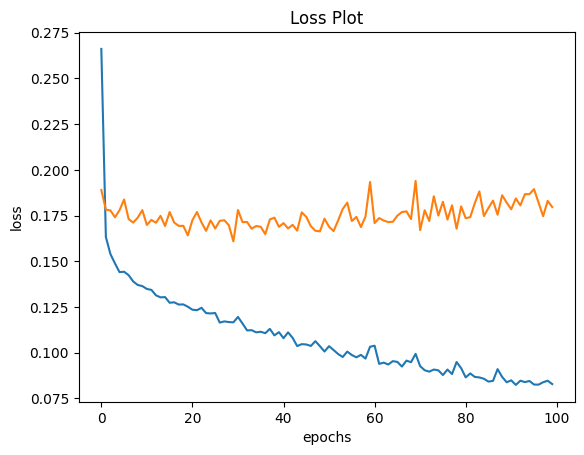

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

xs = np.arange(NUM_EPOCHS)
train_losses = [h[0] for h in history]
val_losses = [h[1] for h in history]
plt.plot(xs, train_losses, label="train")
plt.plot(xs, val_losses, label="val")
plt.title("Loss Plot")
plt.xlabel("epochs")
plt.ylabel("loss")

_ = plt.show()

In [ ]:
torch.save(model.state_dict(),
           os.path.join(data_dir, "pointwise_model"))